In [ ]:
# Cell for possible installation



# Semantic segmentation with Unet( EDA )

In this notebook we will complete exploratory data analysis of the Airbus Ship Detection Challenge dataset.

It's the first part of the whole work done for this challange, the second part is `'Semantic segmentation with Unet( modelling ).ipynb'`, 

in which we will describe a model architecture, training it and validating. In the same notebook we'll submit our results.

### Importing libreries

In [1]:
import os
import sys
import random
import warnings
import PIL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook, tnrange
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage.feature import canny
from skimage.filters import sobel,threshold_otsu, threshold_niblack,threshold_sauvola
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from scipy import signal

import cv2
from PIL import Image
import pdb
from tqdm import tqdm
import seaborn as sns
import os 
from glob import glob

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Loading the data

In [3]:
train = os.listdir("/kaggle/input/airbus-ship-detection/train_v2")
test = os.listdir("/kaggle/input/airbus-ship-detection/test_v2")
print(f"Train files: {len(train)}. ---> {train[:3]}")
print(f"Test files :  {len(test)}. ---> {test[:3]}")
# The directories contain roughly 200,000 and 16,000 images each.

Train files: 192556. ---> ['d8bc90fd6.jpg', 'ee783cf9f.jpg', '4b0d96146.jpg']
Test files :  15606. ---> ['4291f3a66.jpg', 'b0808caaf.jpg', '9f582d5ce.jpg']


In [4]:
df = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")
# we subtract 1 because column names also take one line of the file 
len(df) - 1

231722

In [5]:
submission_df = pd.read_csv("/kaggle/input/airbus-ship-detection/sample_submission_v2.csv")
# we subtract 1 because column names also take one line of the file 
len(submission_df) - 1

15605

Let's play a bit with image displaying

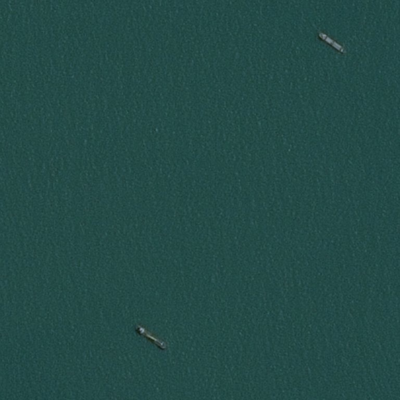

In [6]:
PIL.Image.open(f"/kaggle/input/airbus-ship-detection/train_v2/{train[1212]}").resize((400, 400))

Text(0.5, 0.98, 'Training dataset')

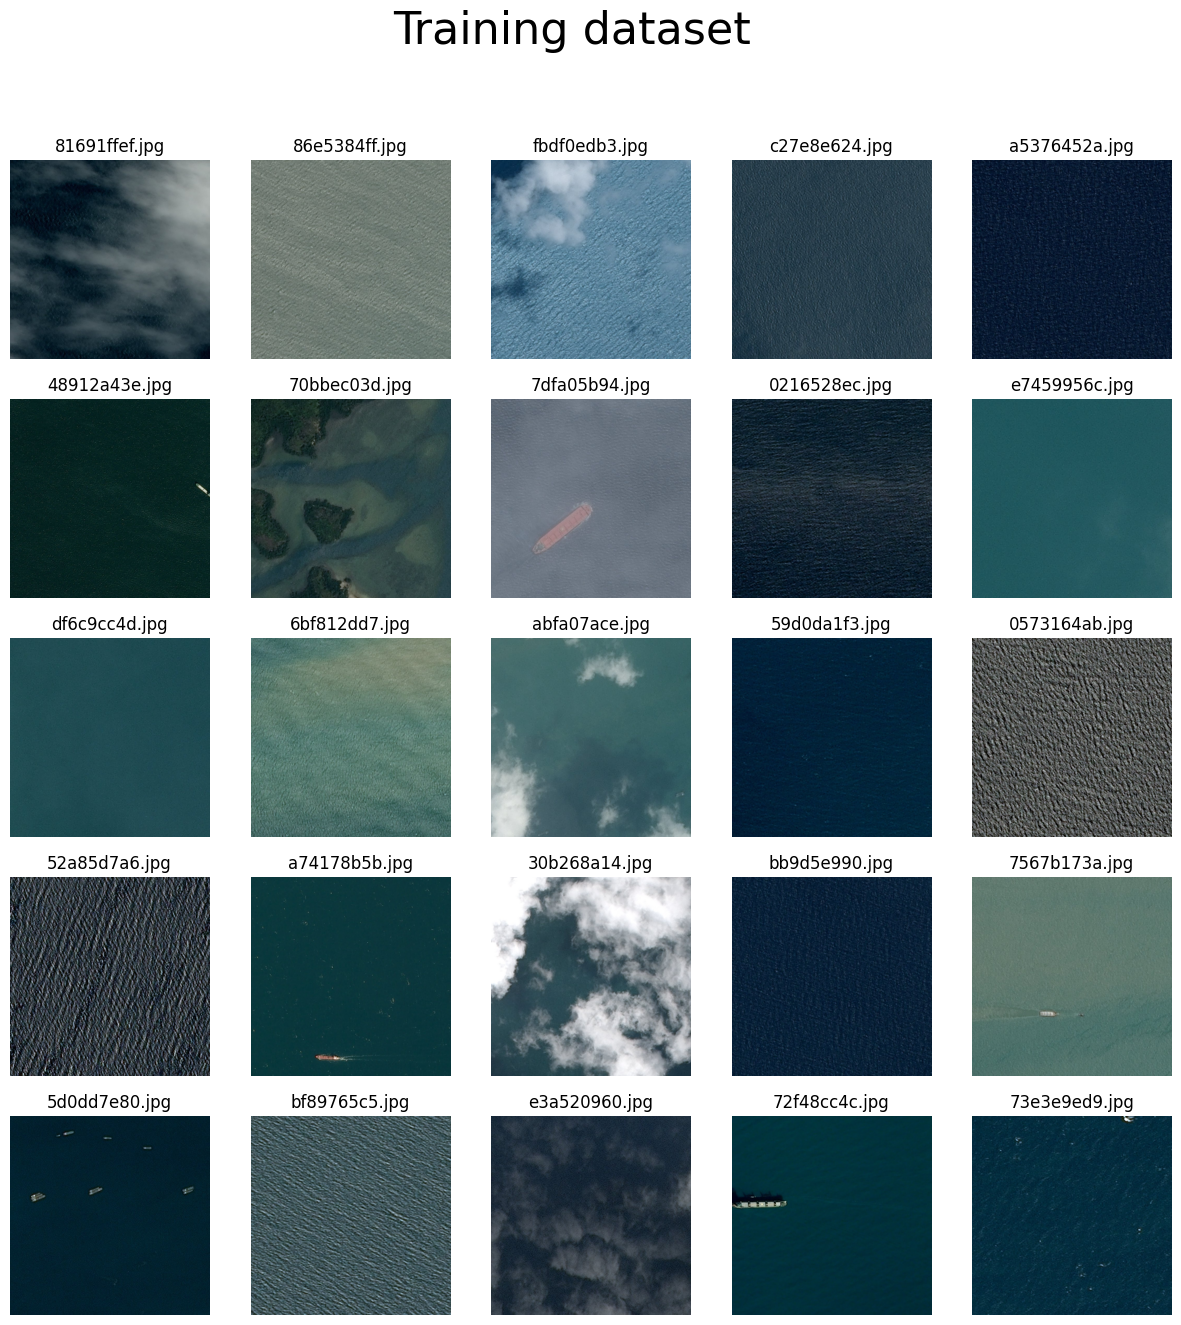

In [7]:
load_img = lambda filename: np.array(PIL.Image.open(f"/kaggle/input/airbus-ship-detection/train_v2/{filename}").resize((200, 200)))

fig, axes_list = plt.subplots(5, 5, figsize=(15, 15)) 

plt.title("Training dataset")
for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        img = np.random.choice(train) 
        ax.imshow(load_img(img))
        ax.set_title(img)
        
fig.suptitle("Training dataset", fontsize=32)

Text(0.5, 0.98, 'Test dataset')

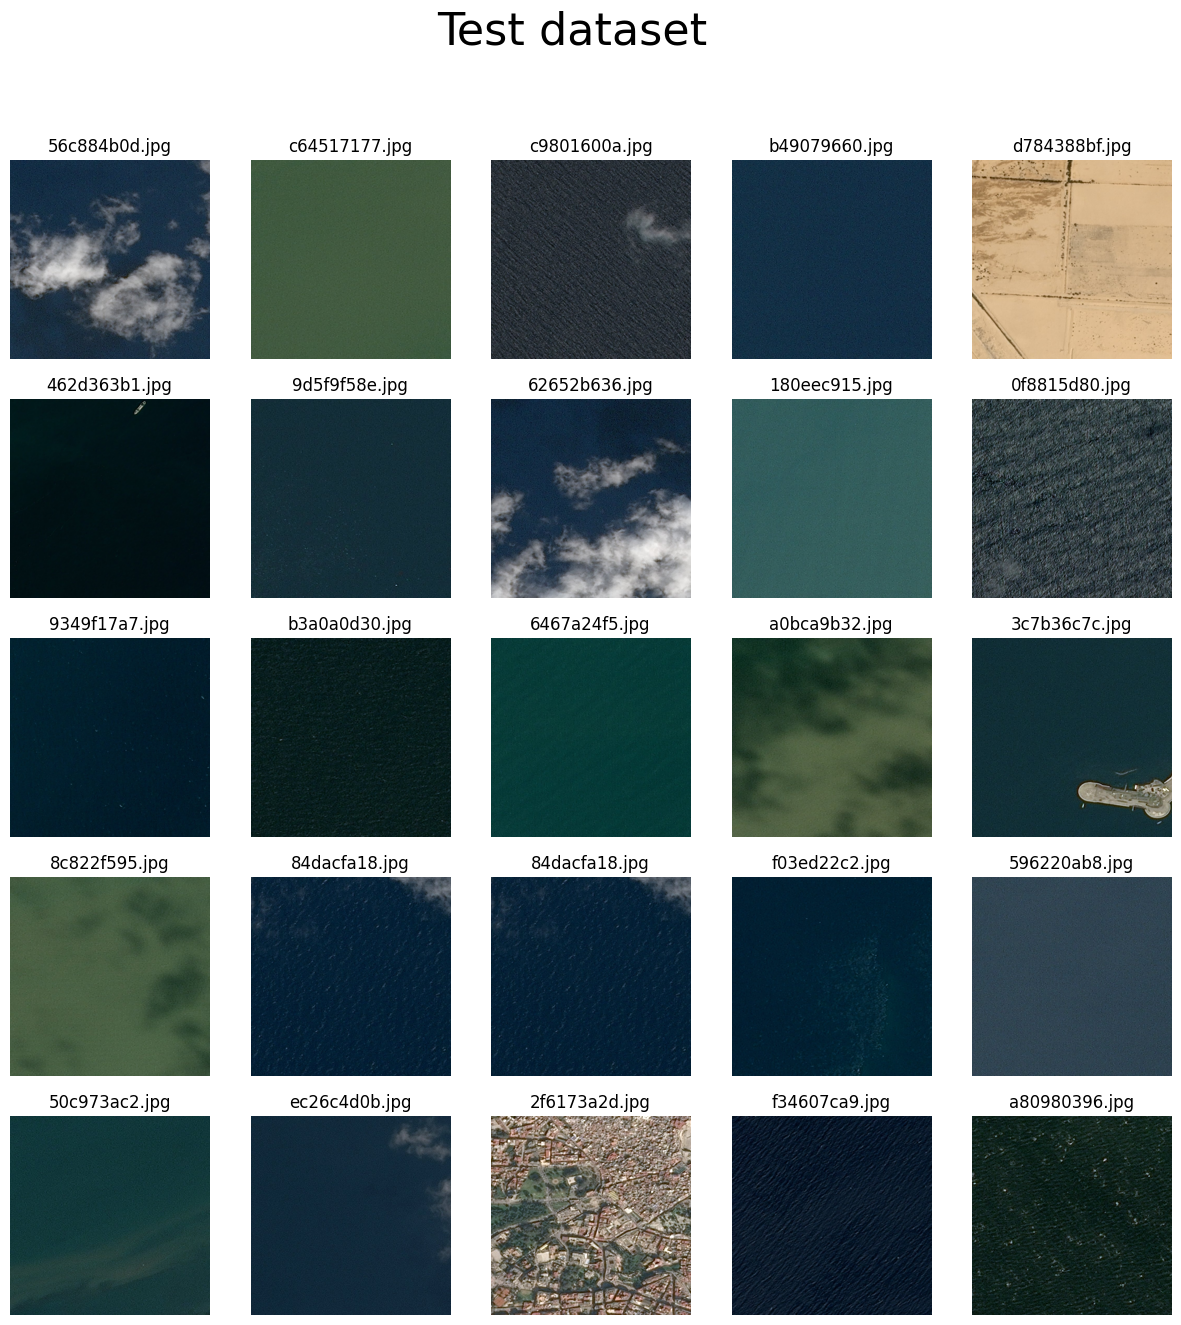

In [8]:
load_img = lambda filename: np.array(PIL.Image.open(f"/kaggle/input/airbus-ship-detection/test_v2/{filename}").resize((200, 200)))

fig, axes_list = plt.subplots(5, 5, figsize=(15, 15)) 

plt.title("Training dataset")
for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        img = np.random.choice(test) 
        ax.imshow(load_img(img))
        ax.set_title(img)
        
fig.suptitle("Test dataset", fontsize=32)

We can see there are a lot of pictures that do not contain any ships at all

In [9]:
df = df.reset_index()
df['ship_count'] = df.groupby('ImageId')['ImageId'].transform('count')
df.loc[df['EncodedPixels'].isnull().values,'ship_count'] = 0

print(df['ship_count'].describe())

count    231723.000000
mean          1.344472
std           2.755929
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          15.000000
Name: ship_count, dtype: float64


Text(0.5, 1.0, 'Train set ship distribution')

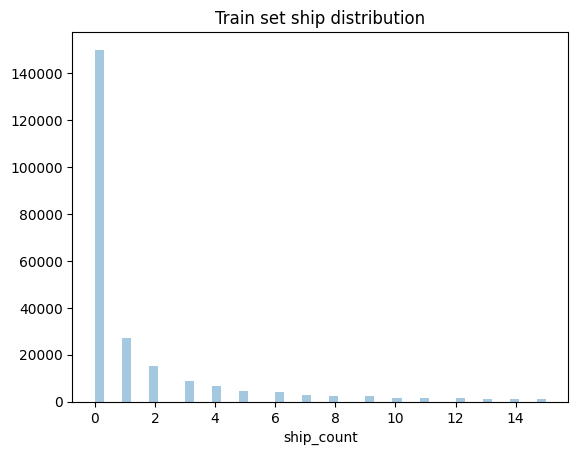

In [10]:
sns.distplot(df['ship_count'],kde=False)
plt.title('Train set ship distribution')

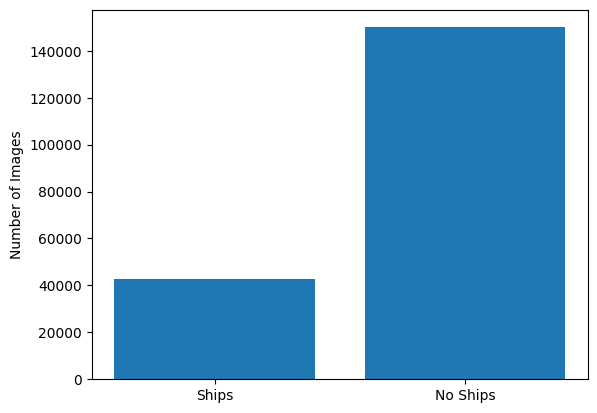

In [11]:
ships = pd.unique(df['ImageId'][df['ship_count']!=0])
noships = pd.unique(df['ImageId'][df['ship_count']==0])

plt.bar(['Ships', 'No Ships'], [len(ships), len(noships)]);
plt.ylabel('Number of Images');

As we thought there is a lot of images that don't contain no ships in them

24    2
25    2
Name: ship_count, dtype: int64


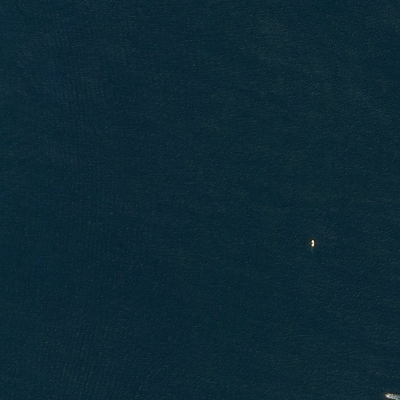

In [12]:
print(df['ship_count'][df['ImageId'] == '000532683.jpg'])

PIL.Image.open(f"/kaggle/input/airbus-ship-detection/train_v2/000532683.jpg").resize((400, 400))

In [13]:
df[df['ship_count'] == 1].head()
# df[df['ImageId'] == '00052ed46.jpg']


index        ImageId                                      EncodedPixels  \
2       2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...   
22     22  00031f145.jpg  340363 1 341129 4 341896 6 342663 7 343429 10 ...   
26     26  00053c6ba.jpg  565382 3 566144 9 566909 12 567677 13 568445 1...   
31     31  0005d6d95.jpg  265143 1 265910 4 266678 5 267445 7 268212 10 ...   
32     32  0006c52e8.jpg  146366 1 147132 4 147899 5 148666 7 149432 10 ...   

    ship_count  
2            1  
22           1  
26           1  
31           1  
32           1

### What is run-length encoding

RLE, for short, is a simple morse-like representation of shapes in 2d images. In this case, what's encoded are some rectangular shapes - the bounding boxes - where the ships are located in the respective images.

The encoded string looks like this: `start, length, start, length, ... `, where each pair of `(start, length)` draws a line of `length` pixeles starting from position `start`. 

The `start` position, in turn, is not a `(x, y)` coordinate but an index of the 1-d array resulting of flattening the 2-d image into a rows-after-row 1-d sequence of pixels. 

Knowing the shape of the images we can just unfold this 1-d representating into a 2-dimensions mask using `//` and `%`.

Let's check it out with a rle code example.

In [14]:
# We're gonna use the same df that represents train_ship_segmentations_v2.csv
df = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv", index_col=0)

df['EncodedPixels']['00053c6ba.jpg']

'565382 3 566144 9 566909 12 567677 13 568445 13 569214 12 569982 12 570750 13 571518 13 572287 12 573055 12 573823 13 574591 13 575360 12 576128 9 576896 3'

In [15]:
def get_start_end(ImageId):
    """turns rle example into a list of ints and then
        turns list of ints into a list of (`start`, `length`) `pairs`"""

    rle = [int(i) for i in df['EncodedPixels'][ImageId].split()]

    pairs = list(zip(rle[0:-1:2], rle[1::2])) 
    pairs[:3]
    
    return pairs
    
pairs = get_start_end('00053c6ba.jpg')

pairs

[(565382, 3),
 (566144, 9),
 (566909, 12),
 (567677, 13),
 (568445, 13),
 (569214, 12),
 (569982, 12),
 (570750, 13),
 (571518, 13),
 (572287, 12),
 (573055, 12),
 (573823, 13),
 (574591, 13),
 (575360, 12),
 (576128, 9),
 (576896, 3)]

Now, as said earlier, we can this 1-d array, that we got, into a 2-d array. In this way we can interpret the array as an array of pixel coordinates.

In [16]:
start = pairs[0][0]
print(f"Original start position: {start}")

coordinate = (start % 768, start // 768)
print(f"Maps to this coordinate: {coordinate}")

back = 768 * coordinate[1] + coordinate[0]
print(f"And back: {back}")

Original start position: 565382
Maps to this coordinate: (134, 736)
And back: 565382


In [17]:
# Finally we can map the list of (start, length) pairs into a list of pixels
def rle_to_pixels(rle_code):
    '''
    With RLE code string as input tranforms it 
    into a list of pixels of a (768, 768) canvas
    '''
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
                 for pixel_position in range(start, start + length)]
    return pixels

First 5 pixels:  [(134, 736), (135, 736), (136, 736), (128, 737), (129, 737)]


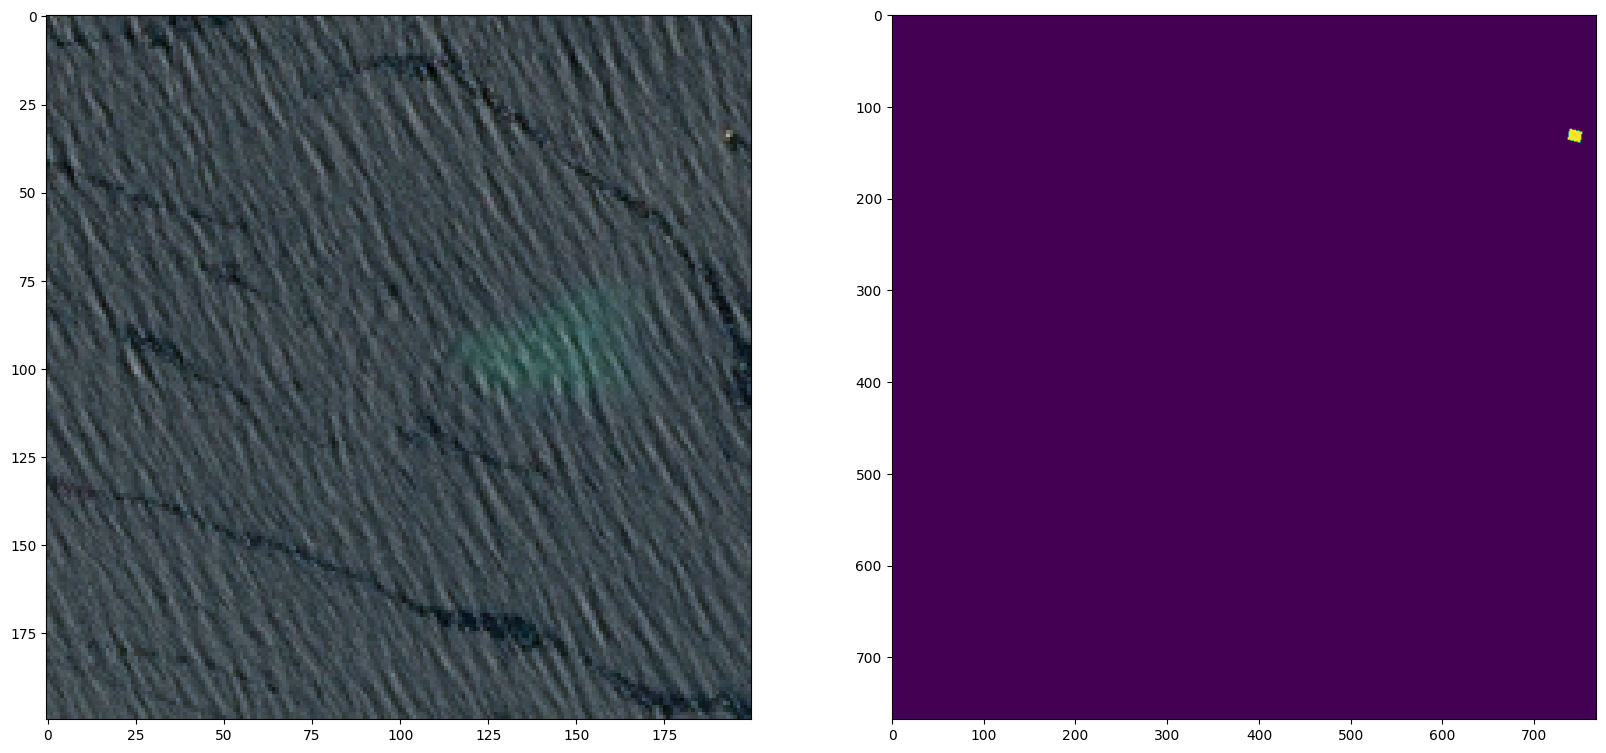

In [18]:
pixels = rle_to_pixels(df['EncodedPixels']['00053c6ba.jpg'])
print("First 5 pixels: ",pixels[:5])


# Create a matrix of shape (768, 768) full of zeros
canvas = np.zeros((768, 768))

# numpy arrays can't be indexed by a list of pairs [(x1, y1), (x2, y2)]
# but it can be indexed with a tuple with ([x1, x2,..., xn], [y1, y2... yn])
# tuple(zip(*)) does exactly this map.... 
# ref: https://stackoverflow.com/questions/28491230/indexing-a-numpy-array-with-a-list-of-tuples
canvas[tuple(zip(*pixels))] = 1

# And this what will happen if we want to see 
# how it actually looks as an image mask
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(PIL.Image.open('/kaggle/input/airbus-ship-detection/train_v2/00053c6ba.jpg').resize((200, 200)))
ax[1].imshow(canvas)

In [19]:
def encodedpixels2rle(encodedpixels):
    if isinstance(encodedpixels, str):
        return np.array(list(zip(*[iter(int(x) for x in encodedpixels.split())]*2)))
    return np.array([])


def rle2mask(rle, shape=(768, 768)):
    """
    rle: 2D numpy array with rows of form [start, run-length]
    shape: (rows, cols) the shape of the referenced image
    """
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    run_ranges = [(start - 1, start + length - 1) for (start, length) in rle]

    for a, b in run_ranges:
        mask[a:b] = 1

    return mask.reshape(shape).T


def read_train_image(imgid):
    return(imread('/kaggle/input/airbus-ship-detection/train_v2/' + imgid))


# def read_test_image(imgid):
#     return(imread('/kaggle/input/airbus-ship-detection/test_v2/' + imgid))


def get_train_combined_masks(imgid):
    return(rle2mask(encodedpixels2rle(' '.join(
        df[df['ImageId'] == imgid]['EncodedPixels'].fillna('').astype(str)))))


def get_train_objcount(imgid):
    return df[df['ImageId'] == imgid]['EncodedPixels'].count()

In [20]:
df = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")

In [21]:
print(df.columns.tolist()) 

['ImageId', 'EncodedPixels']


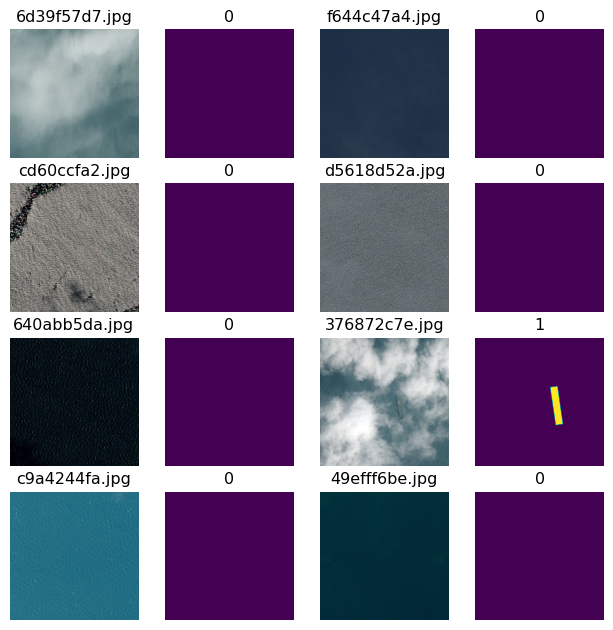

In [22]:
# load_img = lambda filename: np.array(PIL.Image.open(f"/kaggle/input/airbus-ship-detection/train_v2/{filename}").resize((200, 200)))
load_img = lambda filename: np.array(PIL.Image.open(f"/kaggle/input/airbus-ship-detection/test_v2/{filename}").resize((200, 200)))

# fig, axes_list = plt.subplots(5, 5, figsize=(15, 15)) 

# plt.title("Training dataset")
# for axes in axes_list:
#     for ax in axes:
#         img = np.random.choice(train) 
        
#         pixels = rle_to_pixels(df['EncodedPixels'][img])
        
#         canvas = np.zeros((768, 768))
#         canvas[tuple(zip(*pixels))] = 1
        
#         fig, sub_ax = plt.subplots(1, 2, figsize=(15, 15))
        
#         sub_ax[0].imshow(load_img(img))
#         sub_ax[1].imshow(canvas)
        
# fig.suptitle("Train images & their masks", fontsize=32)


fig, ax = plt.subplots(4, 4, figsize=(8, 8), dpi=96)

ax = ax.reshape(-1)

for a in ax: 
    a.axis('off')

imgids = np.random.choice(train, 8, replace=False)

for i, imgid in enumerate(imgids):
    msk = get_train_combined_masks(imgid)
    ax[2*i].imshow(read_train_image(imgid))
    ax[2*i].set_title(imgid)
    ax[2*i+1].imshow(msk)
    ax[2*i+1].set_title("%s" % (get_train_objcount(imgid)))

Based on the exploratory data analysis (EDA) of the Airbus Ship Detection Challenge dataset, the following conclusions can be drawn:

1. **Dataset Overview:**
   - The dataset consists of a training set with 192,556 images and a test set with 15,606 images.
   - The dataset is labeled with ship segmentations, and the labels are provided in the form of encoded pixels.

2. **Image Display:**
   - Displayed random samples from both the training and test datasets to visualize the images.
   - Noticed that there are many images that do not contain any ships.

3. **Ship Distribution:**
   - Analyzed the distribution of the number of ships per image.
   - Found that approximately 78% of the images in the training set do not contain any ships.
   - The majority of images have either no ships or a small number of ships.

4. **RLE Encoding Exploration:**
   - Explored the Run-Length Encoding (RLE) used for representing ship segmentations.
   - Created functions to convert RLE-encoded strings to pixel coordinates and visualize the corresponding masks.

5. **Image and Mask Visualization:**
   - Visualized random images from the training set along with their corresponding ship masks.
   - Demonstrated the conversion of RLE-encoded masks to binary masks for better understanding.

6. **Conclusion:**
    - We can say now, we found out that most of the images (78%) do not contain ships. All the ships in the images take up a very small part (approximately 0,1%), the pictures contain a lot of background. Also, target segmentation for labeled pictures consists of bounding boxes (rectangles). Ships do not intersect, but their borders in some images have adjacent borders.
    
Understanding the distribution of ships in the dataset and the encoding format is essential for building an effective semantic segmentation model in the subsequent modeling phase (`Semantic segmentation with Unet( modelling ).ipynb`).